In [45]:
# Necessary libraries
import pandas as pd
import numpy as np
import csv 
import matplotlib.pyplot as plt

from pandas import read_csv
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings('ignore')

Functions from Nils to do Interpol and ADF/KPSS + differentiating to stationarity

In [31]:
def interpol(df, name_col):
    time = df['wrist@(9mm,809nm)_delay_s']
    data_squashed = df.dropna(subset=[name_col])
    interp_func = interp1d(data_squashed['wrist@(9mm,809nm)_delay_s'].array, data_squashed[name_col].array, kind='linear', fill_value="extrapolate")
    continuous_values = interp_func(time) 
    return continuous_values 
    
    
def ADF(mat):
    result = adfuller(mat, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[2]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}\n')
    if result[1]<= 0.05:
        print("Hypothesis can be rejected --> stationnary")
    else :
        print("Hypothesis cannot be rejected --> not stationnary")
        
def KPSS(mat):
    results = kpss(mat)
    print(f'KPSS Statistic: {results[0]}')
    print(f'n_lags: {results[2]}')
    print(f'p-value: {results[1]}')
    for key, value in results[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}\n')
    if results[1]>= 0.05:
        print("Hypothesis cannot be rejected --> stationnary")
    else :
        print("Hypothesis can be rejected --> not stationnary")
        
def Detrend(mat):
    Diff = np.zeros(mat.shape)
    Diff[0] = mat[0]
    Diff[len(mat)-1]=Diff[len(mat)-1]
    for i in range (1,len(mat)-1,1):
        Diff[i]= np.abs(mat[i]-mat[i-1])
    return Diff


In [34]:
df = pd.read_csv('03-Oct-2023_patAnalysis_2.csv')
name_col ='wrist@(9mm,809nm)_filtered_pat_bottomTI'
mat = interpol(df,name_col)
diff = Detrend(mat)
ADF(Diff)
KPSS(Diff)

ADF Statistic: -4.93708621099973
n_lags: 25
p-value: 2.9518320611714797e-05
Critial Values:
   1%, -3.4331766678108986

Critial Values:
   5%, -2.8627887632196742

Critial Values:
   10%, -2.567434772395083

Hypothesis can be rejected --> stationnary
KPSS Statistic: 0.24718110221952144
n_lags: 27
p-value: 0.1
Critial Values:
   10%, 0.347

Critial Values:
   5%, 0.463

Critial Values:
   2.5%, 0.574

Critial Values:
   1%, 0.739

Hypothesis cannot be rejected --> stationnary


In [42]:
X_stationary = Diff[23:2325] # Stationary  pat values
X_raw = mat[23:2325]
y = df['blood pressure_systolic'].dropna().to_numpy() # Bloodd pressure without NaN values

In [39]:
# Performing interpolation
data_squashed = df.dropna(subset=['wrist@(9mm,809nm)_filtered_pat_bottomTI'])

interp_func = interp1d(data_squashed['wrist@(9mm,809nm)_delay_s'].array, data_squashed['wrist@(9mm,809nm)_filtered_pat_bottomTI'].array, kind='linear', fill_value="extrapolate")
pat_filt_int = interp_func(time)
df['filtered_pat_interpolated'] = pat_filt_int.tolist()
df.head()

,"wrist@(9mm,809nm)_date","wrist@(9mm,809nm)_delay_s","wrist@(9mm,809nm)_raw_pat","wrist@(9mm,809nm)_filtered_pat_bottomTI","wrist@(9mm,809nm)_mask",blood pressure_systolic,blood pressure_mean,blood pressure_diastolic,filtered_pat_interpolated
0,27/10/2022 10:48,0.552,0.309134,NaN,0,NaN,NaN,NaN,0.286187
1,27/10/2022 10:48,1.478,0.785900,NaN,0,NaN,NaN,NaN,0.288708
2,27/10/2022 10:48,2.371,0.214786,0.291140,1,NaN,NaN,NaN,0.291140
3,27/10/2022 10:48,3.219,0.317847,0.293449,1,NaN,NaN,NaN,0.293449
4,27/10/2022 10:48,4.055,0.307355,0.295763,1,NaN,NaN,NaN,0.295763


In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

X =  X_stationary.reshape(-1,1)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)


# Calculate average mean squared error
average_mse = sum(mse_scores) / len(mse_scores)
print("Average Mean Squared Error:", average_mse)




Average Mean Squared Error: 350.8636679460466


Text(0.5, 1.0, 'PAT vs Systolic BP')

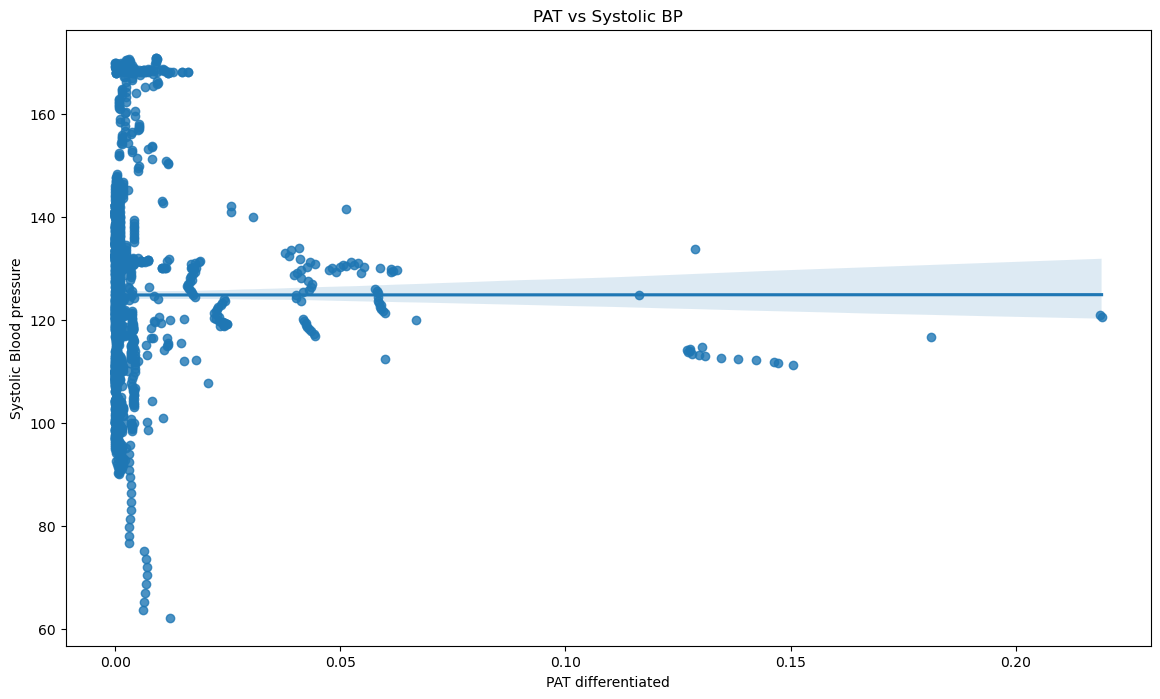

In [49]:
plt.figure(figsize=(14,8))
#sns.regplot(x=bp_systolic,y = pat_filtred)
sns.regplot(x= X_stationary ,y = y)
plt.xlabel("PAT differentiated")
plt.ylabel("Systolic Blood pressure")
plt.title('PAT vs Systolic BP')

In [53]:
print("Correlation coefficien between BP systolic and Filtered Pat: ",np.corrcoef(X_stationary,y, rowvar=False))

Correlation coefficien between BP systolic and Filtered Pat:  [[1.0000000e+00 2.1947082e-04]
 [2.1947082e-04 1.0000000e+00]]


In [27]:
data_squash_bp = df.dropna(subset=['blood pressure_systolic'])
data_squash_bp

,"wrist@(9mm,809nm)_date","wrist@(9mm,809nm)_delay_s","wrist@(9mm,809nm)_raw_pat","wrist@(9mm,809nm)_filtered_pat_bottomTI","wrist@(9mm,809nm)_mask",blood pressure_systolic,blood pressure_mean,blood pressure_diastolic,filtered_pat_interpolated
24,27/10/2022 10:49,22.626,NaN,NaN,0,62.1268,44.71990,41.3756,0.367579
25,27/10/2022 10:49,23.482,NaN,NaN,0,63.6676,45.70430,41.8892,0.373935
26,27/10/2022 10:49,24.377,0.539193,NaN,0,65.2786,46.73355,42.4262,0.380581
27,27/10/2022 10:49,25.307,NaN,NaN,0,66.9526,47.80305,42.9842,0.387487
28,27/10/2022 10:49,26.263,0.725741,NaN,0,68.6734,48.90245,43.5578,0.394585
...,...,...,...,...,...,...,...,...,...
2321,27/10/2022 11:52,3798.134,0.180315,0.185350,1,116.1598,80.15980,60.9665,0.185350
2322,27/10/2022 11:52,3799.034,0.181337,0.185817,1,115.8898,79.88980,60.7415,0.185817
2323,27/10/2022 11:52,3799.944,0.186739,0.186459,1,115.6168,79.61680,60.5140,0.186459
2324,27/10/2022 11:52,3800.842,0.190720,0.187216,1,115.3474,79.34740,60.2895,0.187216


In [24]:
data_squash_bp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2302 entries, 24 to 2325
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   wrist@(9mm,809nm)_date                   2302 non-null   object 
 1   wrist@(9mm,809nm)_delay_s                2302 non-null   float64
 2   wrist@(9mm,809nm)_raw_pat                1733 non-null   float64
 3   wrist@(9mm,809nm)_filtered_pat_bottomTI  1462 non-null   float64
 4   wrist@(9mm,809nm)_mask                   2302 non-null   int64  
 5   blood pressure_systolic                  2302 non-null   float64
 6   blood pressure_mean                      2302 non-null   float64
 7   blood pressure_diastolic                 2302 non-null   float64
 8   filtered_pat_interpolated                2302 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 179.8+ KB


Text(0.5, 1.0, 'PAT vs Systolic BP')

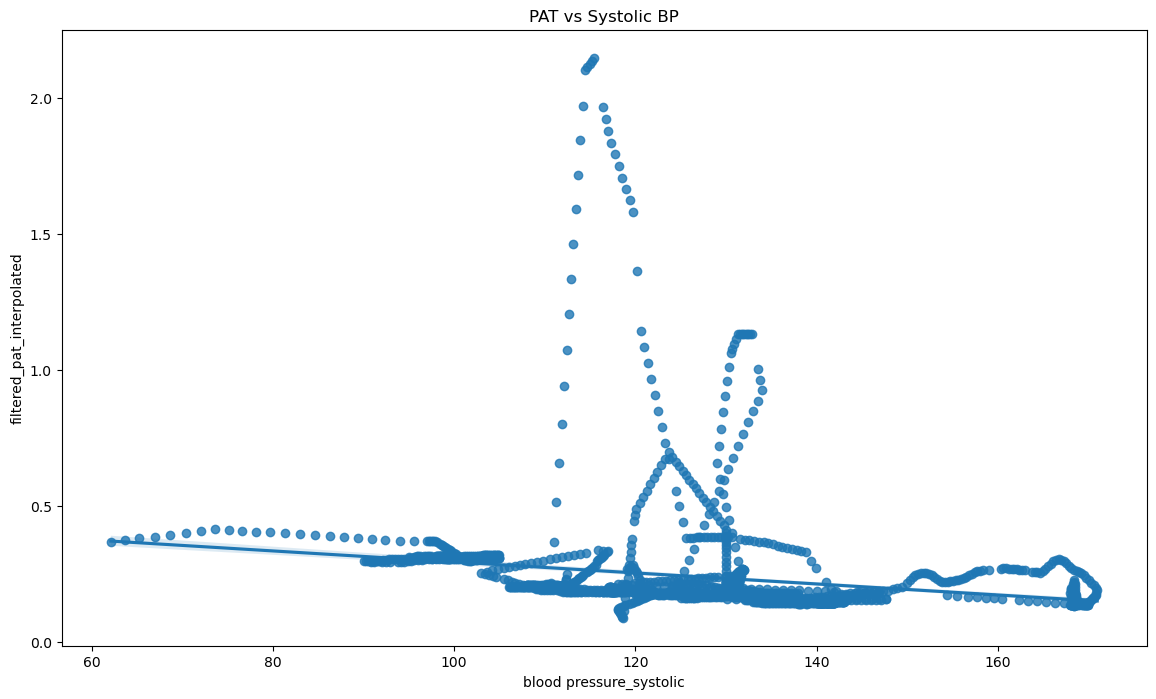

In [28]:
import seaborn as sns
plt.figure(figsize=(14,8))
#sns.regplot(x=bp_systolic,y = pat_filtred)
sns.regplot(x= data_squash_bp['blood pressure_systolic'],y = data_squash_bp['filtered_pat_interpolated'])
plt.title('PAT vs Systolic BP')

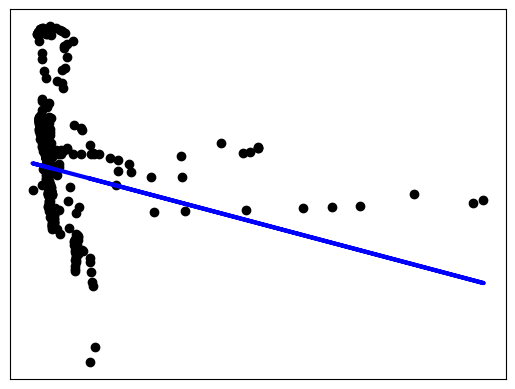

In [26]:
# Plot outputs
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()